# Exploring the topological and geometric relationship between $\mathcal{Z}$ and $\mathcal{M}$

Supporting code for the paper titled [Discovering latent topology and geometry in data: a law of large dimension](https://arxiv.org/abs/2208.11665). Further details and any references in the notebook to theorems, assumptions, etc. can be found there. 

## Package load

In [1]:
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':6,
         'ytick.labelsize':6}
plt.rcParams.update(params)

import tadasets
from sklearn.manifold import TSNE
import sklearn.metrics.pairwise as knl
from sklearn.manifold import Isomap

from ripser import ripser
from persim import plot_diagrams

np.random.seed(123)
%matplotlib inline

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Functions

In [2]:
def pc_scores(X, r, return_eig = None):
    U, s, Vh = sparse.linalg.svds(X,k=r)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    if return_eig is not None:
        return Y, s
    else:
        return Y

In [3]:
#function for mesh plot of torus
def plot_torus(precision, c, a):
    U = np.linspace(0.2, 2*np.pi, precision)
    V = np.linspace(0, 2*np.pi, precision)
    U, V = np.meshgrid(U, V)
    X = (c+a*np.cos(V))*np.cos(U)
    Y = (c+a*np.cos(V))*np.sin(U)
    Z = a*np.sin(V)
    return X, Y, Z

## LMS model and PC scores

<div class="alert alert-block alert-success">
<b>Latent Metric Space model:</b>
The data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$ is defined by:
\begin{equation}
\mathbf{Y}_{ij} := X_{j}(Z_{i})+\sigma\mathbf{E}_{ij}\label{eq:model}
\end{equation}
for some $\sigma\geq0$. 
</div>

Where, 
* **Latent variables:** $Z_{1},\ldots,Z_{n}$ are random elements of a compact metric space $(\mathcal{Z},d_{\mathcal{Z}})$, i.i.d. according to a Borel probability measure $\mu$ supported on $\mathcal{Z}$. 
* **Random fields:** $X_{1},\ldots,X_{p}$ are independent but not necessarily identically distributed, $\mathbb{R}$-valued and square-integrable random fields, each with index set $\mathcal{Z}$. That is, for each $z\in\mathcal{Z}$ and $j=1,\ldots,p$, $X_{j}(z)$ is an $\mathbb{R}$-valued random variable such that $\mathbb{E}[|X_{j}(z)|^{2}]<\infty$.
* **Noise:** $\mathbf{E}\in\mathbb{R}^{p\times n}$ is a matrix of random variables whose elements are each zero-mean and unit-variance. The columns of $\mathbf{E}$ are assumed independent and elements in distinct rows of $\mathbf{E}$ are assumed pairwise uncorrelated.
***

<div class="alert alert-block alert-success">
<b>PC scores:</b> For data matrix $Y \in \mathbb{R}^{n\times p}$ the PC scores are defined by:
$$[\zeta_1| \dots | \zeta_n]^\top = \mathbf{Y} \mathbf{V}_{\mathbf{Y}} = p^{1/2} \mathbf{U}_{\mathbf{Y}} \boldsymbol{\Lambda}_{\mathbf{Y}} ^{1/2}. $$
where $\boldsymbol{\Lambda}_{\mathbf{Y}}\in\mathbb{R}^{r\times r}$
is the diagonal matrix whose diagonal elements are the $r$ largest eigenvalues of $p^{-1}\mathbf{Y}\mathbf{Y}^{\top}$, and the columns
of $\mathbf{U}_{\mathbf{Y}}\in\mathbb{R}^{n\times r}$ are orthonormal
eigenvectors associated with these eigenvalues and $\mathbf{V}_{\mathbf{Y}}\in\mathbb{R}^{p\times r}$ are orthonormal eigenvectors associated with the $r$ largest eigenvalues of $\mathbf{Y}^{\top}\mathbf{Y}$.
</div>

***

# Introduction

Theorem 1 tells us that, up to an orthogonal transformation, the scaled PC scores $\{p^{-1/2}\zeta_{i};i=1,\ldots,n\}$ are uniformly concentrated around the corresponding points $\{\phi(Z_{i});i=1,\ldots,n\}$. These latter points are each valued in $\mathcal{M} := \phi(\mathcal{Z})$, the image of $\mathcal{Z}$ by $\phi$. Here, we explore how $\mathcal{M}$ is topologically and geometrically related to $\mathcal{Z}$, allowing us to understand how the PC scores convey the structure of $\mathcal{Z}$. 

As an example, we look at when $\mathcal{Z}$ is a torus embedded in $\mathbb{R}^3$ and $\mu$ is the uniform distribution on the torus. Below is a figure of $Z_1, \dots, Z_{4000}$ simulated from $\mu$. As the torus is the Cartesian product of two circles, the colouring indicates the location of a point in terms of these two angles -- the angle in the horizontal plane is called the *azimuth* and the angle in the vertical plane is called the *elevation*.

In [4]:
#sample uniformly from torus
n = 2000; tor_rad = 0.25; tor_c = 1
Z = tadasets.torus(n,tor_c,a=tor_rad)
color_t1 = np.arctan2(Z[:,0],Z[:,1]) #colour by azimuth about origin
color_t2 = np.arctan2(Z[:,2],-(tor_c-(Z[:,0]**2+Z[:,1]**2)**0.5)) #colour by angle of elevation about center of tube

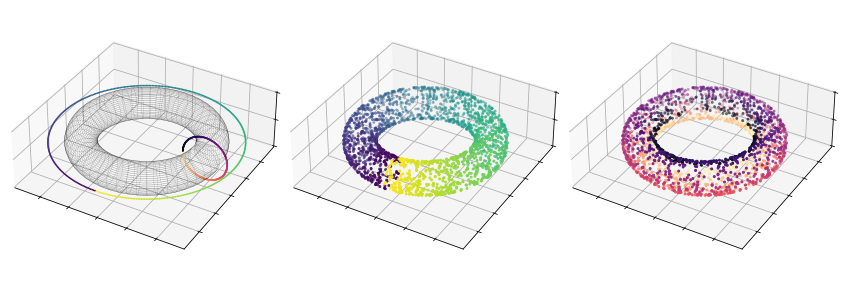

In [5]:
x, y, z = plot_torus(100, tor_c, tor_rad)

#arrays used for plotting colourbar rings
theta_1 = np.linspace(0, 2*np.pi, 400)
theta_2 = np.linspace(0, 2*np.pi, 400)
circ_1_y = -(tor_c+2*tor_rad)*np.cos(theta_1)
circ_1_x = -(tor_c+2*tor_rad)*np.sin(theta_1)
circ_1_z = np.zeros(400)
circ_2_x = tor_c-1.5*tor_rad*np.cos(theta_2)
circ_2_y = np.zeros(400)
circ_2_z = -1.5*tor_rad*np.sin(theta_2)

fig = plt.figure(figsize=(15,5))

#plot the colormap rings and the wireframe torus
ax = fig.add_subplot(131, projection='3d')
ax.scatter3D(circ_2_x, circ_2_y, circ_2_z, c=cm.magma(np.linspace(1, 0, 400)), s=0.5, alpha=1 )
ax.scatter3D(circ_1_x, circ_1_y, circ_1_z, c=cm.viridis(np.linspace(0, 1, 400)), s=0.5, alpha=1)
ax.plot_wireframe(x, y, z, color = 'k', linewidth = 0.1, alpha=0.8, cstride=2, rstride=2)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)
ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))

#now add the sampled points, coloured according their ring coordinates
ax = fig.add_subplot(132, projection='3d')
ax.scatter(Z[:,0],Z[:,1],Z[:,2],marker='o',c=color_t1, s=4, cmap='viridis')
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)
ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))

ax = fig.add_subplot(133, projection='3d')
ax.scatter(Z[:,0],Z[:,1],Z[:,2],marker='o',c=-color_t2, s=4, cmap='magma')
ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-0.5,0.5)
ax.set_zlim(-0.5,0.5)
ax.set_zticks([-0.5,0,0.5])
ax.tick_params(labelbottom=False, labelleft=False)
ax.elev = 35

world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))

plt.subplots_adjust(wspace=0)

On the left we have a grey wireframe of $\mathcal{Z}$ with colour bars indicating the angles of these two cicles, and the middle and right plots show the simulated points coloured by their coordinate with respect to these two circles. 

***

We assume all the fields $X_{j}$ are equal in distribution, with $\mathbb{E}[X_{j}(z)]=0$ for all $z\in\mathcal{Z}$, so that $f(z,z^{\prime})=\mathbb{E}[X_{j}(z)X_{j}(z^{\prime})]$ for $j=1,\ldots,p$. Furthermore we take the fields to be Gaussian processes with a radial basis function kernel as their common covariance
kernel, that is $f(z,z^{\prime})=\exp(-\|z-z^{\prime}\|_{\mathbb{R}^{3}}^{2})$, which satisfies assumptions A1 and A4, hence by lemma 2, $\mathcal{M}$ is topologically equivalent to $\mathcal{Z}$. Assumption A3 does not hold.

Below we show the first 9 dimensions of the PC scores, using $p=5000, \sigma = 0$ (chosen to make the following figure visually clear).

In [6]:
p = 5000
r = 20
sigma = 0 
K = knl.rbf_kernel(Z,gamma=1)

In [7]:
# generate gaussian data
X = np.random.multivariate_normal(np.zeros(n),K+sigma**2*np.eye(n),size=p).T

In [8]:
zeta, s = pc_scores(X, r, return_eig = True)
# factor of p^-.5 included - see main consistency theorem 
zeta = p**-.5 * zeta

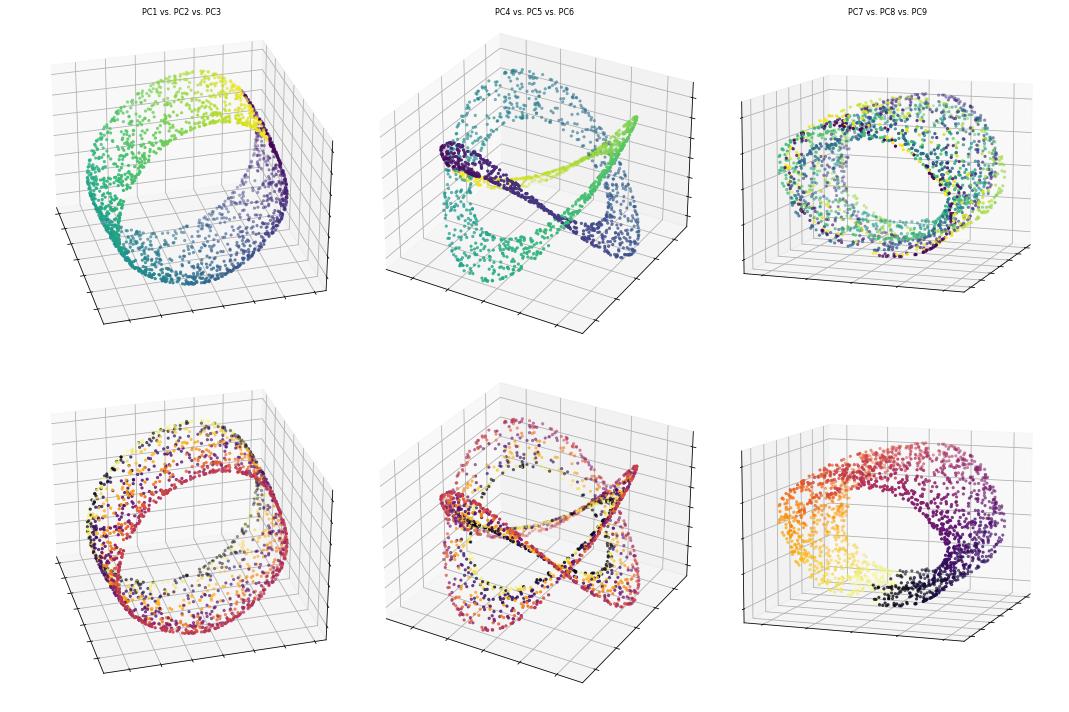

In [9]:
my_cmap = 'viridis'

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', c=color_t1, s=5, cmap=my_cmap) 
ax.azim=-15
ax.set_title('PC1 vs. PC2 vs. PC3', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)
ax.zaxis.set_tick_params(labelsize=6)

ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o', c=color_t1, s=5, cmap=my_cmap)
ax.set_title('PC4 vs. PC5 vs. PC6', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', c=color_t1, s=5, cmap=my_cmap)
ax.azim=20
ax.elev = 10
ax.set_title('PC7 vs. PC8 vs. PC9', pad=-8, fontsize=8)
ax.tick_params(labelbottom=False, labelleft=False)

my_cmap = 'inferno'

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', c=-color_t2, s=5, cmap=my_cmap) 
ax.azim=-15
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o', c=-color_t2, s=5, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(236, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', c=-color_t2, s=5, cmap=my_cmap)
ax.azim=20
ax.elev = 10
ax.tick_params(labelbottom=False, labelleft=False)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace= 0  )

The top and bottom rows show the first 9 dimensions of the PC scores, the points are coloured according to the underlying points $\{Z_1,\dots, Z_n\}$ -- the top rows according to the azimuth angle and the bottom row according to the elevation angle. The first 6 dimensions appear to reflect the azimuth angle and the 7th-9th dimensions reflect the elevation angle.

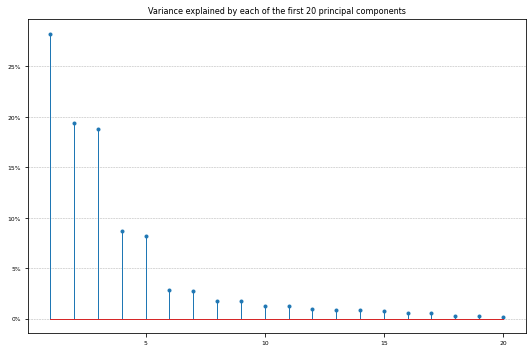

In [10]:
fig = plt.figure(figsize = (7.5,5))
ax = fig.add_subplot(111)
r_plot = 20
percent_var = s[0:r_plot]**2/sum(s**2)

markerline, stemline, baseline, = ax.stem(range(1,r_plot+1),100*percent_var)
ax.set_xticks([5,10,15,20])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_title('Variance explained by each of the first 20 principal components', fontsize = 8)

plt.setp(stemline, linewidth = 1)
plt.setp(markerline, markersize = 3)
plt.setp(baseline, linewidth = 1)

fig.subplots_adjust(hspace=-.2)
fig.tight_layout()

# Topological equivalence of $\mathcal{M}$ and $\mathcal{Z}$

Techniques from TDA are used to estimate topological features of a point cloud, such as the number of connected components, numbers of holes, cavities, etc. As a result of theorem 1 and lemma 2, we have topological equivalence of $\mathcal{M}$ and $\mathcal{Z}$ meaning that by applying these persistent homology techniques to the points cloud of PC scores we can estimate the topological features of the latent domain $\mathcal{Z}$.

Below we compute persistence diagrams associated with the latent positions and the PC scores. A point $(x,y)$ signifies a topological feature born at scale $x$ and persists until scale $y$ and below we show points for connected components (Dim 0) and 1-dimensional holes (Dim 1).

In [11]:
#sample uniformly from torus
# use n = 2000 for speed
# include noise 
n = 2000; p = 5000; r = 20; sigma = .5
tor_rad = 0.25; tor_c = 1
Z = tadasets.torus(n,tor_c,a=tor_rad)

color_t1 = np.arctan2(Z[:,0],Z[:,1]) #colour by azimuth about origin
color_t2 = np.arctan2(Z[:,2],-(tor_c-(Z[:,0]**2+Z[:,1]**2)**0.5)) #colour by angle of elevation about center of tube

K = knl.rbf_kernel(Z,gamma=1)
# generate gaussian data
X = np.random.multivariate_normal(np.zeros(n),K+sigma**2*np.eye(n),size=p).T

In [12]:
zeta, s = pc_scores(X, r, return_eig = True)
# factor of p^-.5 included - see main consistency theorem 
zeta = p**-.5 * zeta

In [13]:
diagrams_Z = ripser(Z, maxdim=1)['dgms']
diagrams_zeta_partial = ripser(zeta[:,0:6], maxdim=1)['dgms']
diagrams_zeta_full = ripser(zeta[:,0:r], maxdim=1)['dgms']
diagrams  = [diagrams_Z,diagrams_zeta_partial,diagrams_zeta_full]

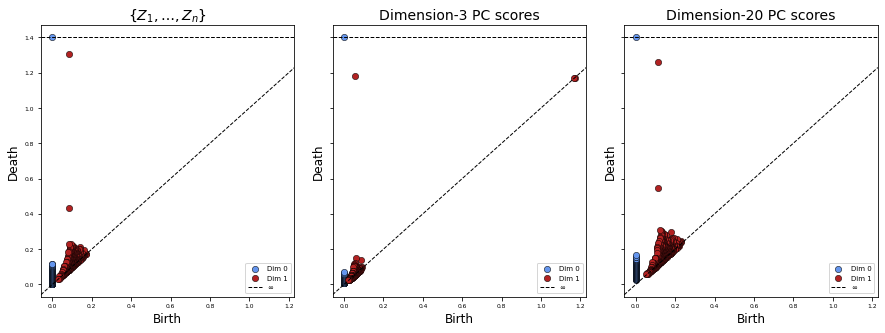

In [14]:
inf_line = 1.4
fig, ax = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

for i in range(0,len(diagrams)):
    diagrams[i][0][diagrams[i][0] == np.inf] = inf_line
    diagrams[i][1][diagrams[i][1] == np.inf] = inf_line
    
    ax[i].scatter(x=diagrams[i][0][:,0], y=diagrams[i][0][:,1],c = 'cornflowerblue', edgecolor='black',linewidth=.5, s = 40, label = 'Dim 0');
    ax[i].scatter(x=diagrams[i][1][:,0], y=diagrams[i][1][:,1],c = 'firebrick', edgecolor='black',linewidth=.5, s = 40, label = 'Dim 1');
    ax[i].axline((0, 0), slope=1,linestyle='--', color='black', lw=1, label = r'$\infty$')
    ax[i].axhline(y = inf_line,linestyle='--', color='black', lw=1)
    ax[i].set_xlabel('Birth', fontsize=12)
    ax[i].set_ylabel('Death', fontsize=12)
    ax[i].legend(loc='lower right');

ax[0].set_title(r'$\{Z_1,\dots, Z_n\}$',fontsize=14)
ax[1].set_title(r'Dimension-3 PC scores',fontsize=14)
ax[2].set_title(r'Dimension-20 PC scores',fontsize=14)
plt.subplots_adjust(wspace=0.15)

For $\mathcal{Z}$ the true number of connected components is 1, and the true number of 1-dimensional holes is 2, corresponding to the two circles of a torus. This is reflected in the left-most persistence diagram. The resemblance of the left and right persistence diagrams demonstrates that the dimension-20 PC scores convey both of the two 1-dimensional holes that are present in $\mathcal{Z}$, whereas the middle persistence diagram shows the dimension-3 PC scores reflect only 1 rather than 2 holes.

Note: In all three the maximum death scale considered was 1.4, and in each plot, the blue dot at coordinates (0.0, 1.4) corresponds
to a connected component which persisted to this maximum death scale.

# Geometric relationships of $\mathcal{M}$ and $\mathcal{Z}$

As the assumption A5 also holds, we now demonstrate how proposition 3 allows us to relate the geometry of $\mathcal{M}$ to that of $\mathcal{Z}$. From proposition 3, the geodesic distance (distance along the manifold) between $\phi(Z_i)$ and $\phi(Z_j)$ is equal to $Z_i$ and $Z_j$ with respect to a Riemannian metric -- in particular, with $f(z,z') = \exp (-\|z-z'\|^2_{\mathbb{R^3}})$, geodesic distance between $\phi(Z_i)$ and $\phi(Z_j)$ will be equal to $Z_i$ and $Z_j$ with a scaling of $\sqrt{2}$. As the PC scores provide consistent estimates of their corresponding points on the manifold they can be used to estimate the geodesic distances, this is shown below along with the theoretical relationship. 

These geodesic distances were estimated using the $k$-nearest neighbour functionality of Isomap: for each of the two point clouds $\{Z_1 , \dots , Z_n\}$ and $\{p^{−1/2} \zeta_1 , \dots , p^{−1/2} \zeta_n \}$, this procedure constructs a 5-nearest neighbour graph with edges weighted by Euclidean distances (in respectively $\mathbb{R}^3$ and $\mathbb{R}^{20}$), and then returns graph distances in these weighted graphs as estimates of geodesic distances.

In [15]:
# compute the approximate geodesic distances in Z and M using 5nn graph
embedding = Isomap(n_components=3, n_neighbors=5)
isomap_M = embedding.fit_transform(zeta)
dist_mat_M = embedding.dist_matrix_

embedding_Z = Isomap(n_components=3, n_neighbors=5)
_ = embedding_Z.fit_transform(Z)
dist_mat_Z = embedding_Z.dist_matrix_

The theoretical relationship between geodesic distance in $\mathcal{Z}$ and $\mathcal{M}$ is shown in the red line and estimate geodesic distances from $\{Z_1 , \dots , Z_n\}$ and $\{p^{−1/2} \zeta_1 , \dots , p^{−1/2} \zeta_n \}$ are shown with blue points.

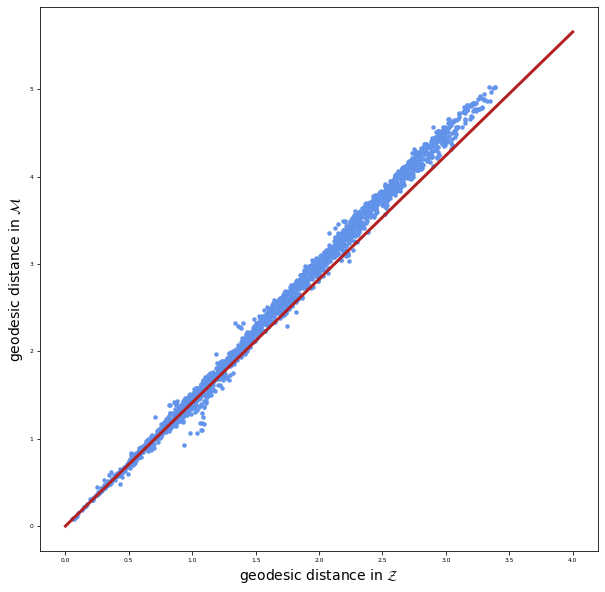

In [16]:
#plot geodesic distance in M against that in Z 
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.scatter(dist_mat_Z[np.triu_indices(n,k=1)][0:n], dist_mat_M[np.triu_indices(n,k=1)][0:n],c = 'cornflowerblue', edgecolor='black',linewidth=.01, s = 20)

#for rbf kernel with gamma=1,H_z = 2 I for all z, and NB need to take square root: <x,H_z x>^1/2, hence sclaing factor of 2^1/2
ax.plot(np.array([0,4]),2**0.5*np.array([0,4]), color='firebrick',linewidth=3)
ax.set_xlabel('geodesic distance in $\mathcal{Z}$', fontsize=14);
ax.set_ylabel('geodesic distance in $\mathcal{M}$', fontsize=14);

There are many nonlinear dimension reduction techniques which take as input a set of points in high-dimensional space, and output a representation of this data in low-dimensional space in a way designed to minimise some measure of distortion of pairwise distances. Preprocessing data by computing PC scores, before applying nonlinear dimension reduction is often used in practice. This paper provides statistical justification for this recommendation: PCA can act to suppress noise while bringing the dimension from high to moderate dimension, and then nonlinear dimension reduction can work to unfold the manifold, conveying the structure of the latent metric space while reducing the dimension further. This reinforces the message that the combination, *linear then nonlinear dimensionality reduction*, may be particularly effective. 

<div class="alert alert-block alert-success">
    
***
**Algorithm** Linear then nonlinear dimensionality reduction.
***
    
**Input:**  data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$.

* Compute the $r$-dimensional PC scores $p^{-1/2}\zeta_{1},\ldots,p^{-1/2}\zeta_{n}$,
to reduce data from high dimension $p$ to moderate dimension $r$.
* Apply a nonlinear dimension reduction technique to $p^{-1/2}\zeta_{1},\ldots,p^{-1/2}\zeta_{n}$,
yielding a low-dimensional representation $\hat{Z}_{1},\ldots,\hat{Z}_{n}$.

**Output:** $\hat{Z}_{1},\ldots,\hat{Z}_{n}$.
    
***
</div>

Below we apply this using two nonlinear dimension reduction techniques: Isomap and $t$-SNE (with default initialisation in $t$-SNE).

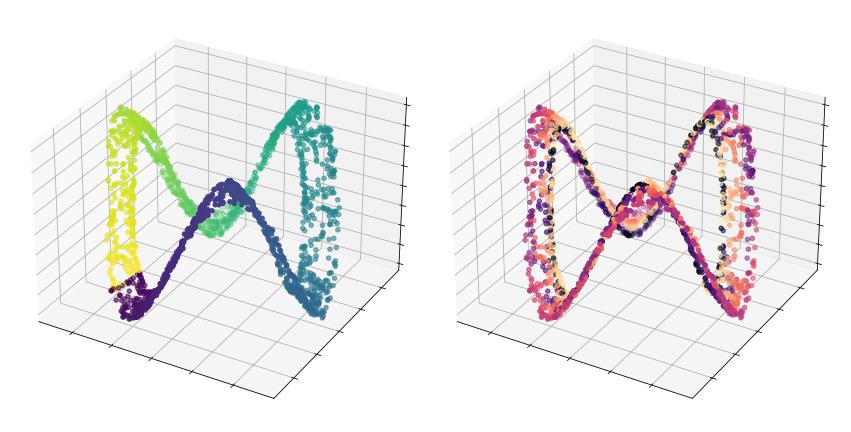

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(isomap_M[:,0],isomap_M[:,1],isomap_M[:,2],marker='o',c=color_t1, s=20, cmap='viridis');
ax.tick_params(labelbottom=False, labelleft=False)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(isomap_M[:,0],isomap_M[:,1],isomap_M[:,2],marker='o',c=color_t2, s=20, cmap='magma');
ax.tick_params(labelbottom=False, labelleft=False)
plt.subplots_adjust(wspace=0, hspace= 0  )

In [18]:
tsne = TSNE(n_components=3, verbose=1, perplexity=200, n_iter=500)
tsne_results = tsne.fit_transform(zeta)

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.379724
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.946037
[t-SNE] KL divergence after 500 iterations: 0.213025


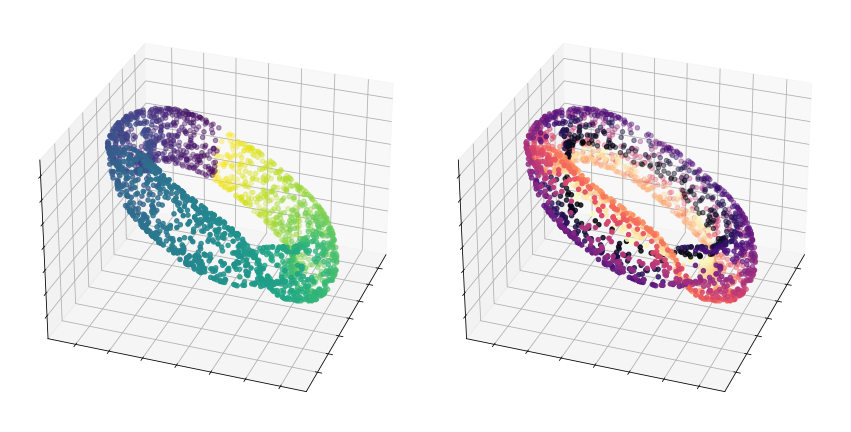

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1],tsne_results[:,2],marker='o',c=color_t1, s=20, cmap='viridis');
ax.tick_params(labelbottom=False, labelleft=False)
ax.azim=20
# ax.elev = 10

ax = fig.add_subplot(122, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1],tsne_results[:,2],marker='o',c=color_t2, s=20, cmap='magma');
ax.tick_params(labelbottom=False, labelleft=False)
ax.azim=20

plt.subplots_adjust(wspace=0, hspace= 0)

It is clear both have recovered the two circles of a torus and $t$-SNE is able to reconstruct the torus structure of $\mathcal{Z}$.